# Arbitrary precision rational Remez

## Prelude

In [3]:
!pip install matplotlib numpy mpmath watermark

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [4]:
%matplotlib inline

import itertools
import math

import matplotlib
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual

In [5]:
# Defaults more suitable for 4K monitors
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = [6.0, 4.0]
# Change font to match Latex
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'CMU Serif'
# Export settings
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.facecolor"] = 'white'
# High compression lossless WebP for animations using ffmpeg -> libwebp
mpl.rcParams["animation.writer"] = 'ffmpeg'
mpl.rcParams["animation.codec"] = 'webp'
mpl.rcParams["animation.ffmpeg_args"] = ["-lossless", "1", "-qscale", "100"]
# Use anim.save("movie.webp", fps=60)

In [8]:
# Use a thousand bits of precision in mp
mp.prec = 1000

In [9]:
import watermark.watermark as watermark
print(watermark(machine=True, iso8601=True, python=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

matplotlib: 3.5.1
numpy     : 1.22.1



## Target

In [1003]:
def f(x):
    return mp.exp(x)

start = -0.5 * mp.log(2)
stop = 0.5 * mp.log(2)

In [1004]:
(start, stop)

(mpf('-0.346573590279972654708616060729088284037750067180127627060340004746696810984847357802931663498209343771000740510285342866842760117879065278516335375817537972'),
 mpf('0.346573590279972654708616060729088284037750067180127627060340004746696810984847357802931663498209343771000740510285342866842760117879065278516335375817537972'))

## Utils

In [1005]:
def linspace(start, stop, n):
    return [start + (stop - start) * mp.mpf(i) / (n - 1) for i in range(n)]

In [1006]:
def plot(h):
    x = linspace(start, stop, 1000)
    yf = [f(x) for x in x]
    yh = [h(x) for x in x]
    
    e = [yh - yf for yh, yf in zip(yh, yf)]
    em = np.max(np.abs(e))
    print(f'Maximum absolute error: {float(em)}')
    
    fig = plt.figure()
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212, sharex = ax1)

    ax1.set_title('Function approximation')
    ax1.plot(x, yf, color='blue', label='truth')
    ax1.plot(x, yh, color='orange', label='approximation')
    ax1.legend()
    
    ax2.set_title('Approximation error')
    ax2.plot(x, e, color='red', label='error')
    ax2.axhline(0, color='black', linestyle='solid')
    ax2.axhline(-em, color='red', linestyle='dashed')
    ax2.axhline(em, color='red', linestyle='dashed')

In [1007]:
def plot_roots(q):
    roots = mp.polyroots(list(reversed(q)))
    plt.scatter([root.real for root in roots], [root.imag for root in roots])

## Chebyshev

In [1008]:
def chebyshev_nodes(start, stop, n):
    x = []
    c = (start + stop) / 2
    s = (stop - start) / 2
    for i in range(n):
        f = (2 * mp.mpf(i) + 1 ) / (2 * n)
        x.append(c + s * mp.cos(f * mp.pi))
    return x

In [1009]:
def ratfn(p ,q):
    pr = list(reversed(p))
    qr = list(reversed(q))
    def h(x):
        return mp.polyval(pr, x) / mp.polyval(qr, x)
    return h

In [1010]:
def rational(n, m):
    global f, start, stop
    x = chebyshev_nodes(start, stop, n + m - 1)
    y = [f(x) for x in x]
    M = mp.matrix(n + m - 1)
    for i in range(M.rows):
        for j in range(n):
            M[i, j] = x[i] ** j
        for j in range(m - 1):
            M[i, j + n] = - y[i] * x[i] ** (j + 1)
    r = list(mp.lu_solve(M, y))
    p, q = r[:n], [mp.mpf(1)] + r[n:]
    
    # Make sure q has no roots in the domain
    for root in mp.polyroots(list(reversed(q))):
        # Real roots in the domain
        if type(root) == mp.mpf and root >= start and root <= stop:
            raise ZeroDivisionError("Zeros in denominator")
    
    return (p, q, ratfn(p, q))

## Remez

In [1011]:
def golden_section_search(f, a, b):
    c = b - (b - a) / mp.phi
    d = a + (b - a) / mp.phi
    while not mp.almosteq(a, b):
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a) / mp.phi
        d = a + (b - a) / mp.phi
    return (b + a) / 2

In [1012]:
def winnow_extrema(x, y, n):
    best = None
    best_s = None
    best_score = None
    sx = x[:n]
    sy = y[:n]
    for s in itertools.combinations(range(len(x)), n):
        assert len(s) == n
        
        # Construct candidate subsequence
        for i, j in zip(range(n), s):
            sx[i] = x[j]
            sy[i] = y[j]
        
        # Test for alternating
        alternating = True
        for i in range(n - 1):
            if mp.sign(sy[i]) != -mp.sign(sy[i + 1]):
                alternating = False
                break
        if not alternating:
            continue
        
        # Score sequence
        score = (min([abs(sy) for sy in sy]), max([abs(sy) for sy in sy]))
        # print(s, f'{(float(score[0]),float(score[1]))}')
        if best_score is None or score > best_score:
            best = (sx[:], sy[:])
            best_s = s[:]
            best_score = score
    
    if best is None:
        raise "No valid subsquence found"
    
    # print(best_s, f'{(float(best_score[0]),float(best_score[1]))}')
    return best

In [1013]:
def remez_guess(h, n):
    # Find initial extrema by grid search.
    x = linspace(start, stop, 1000)
    yf = [f(x) for x in x]
    yh = [h(x) for x in x]
    e = [yh - yf for yf, yh in zip(yf, yh)]
    d = [n - p for n, p in zip(e[1:], e[:-1])]
    xm = [start]
    for i in range(len(d) - 1):
        if mp.sign(d[i]) != mp.sign(d[i + 1]):
            assert x[i] <= x[i + 1]
            assert x[i + 1] <= x[i + 2]
            # Refine by location
            # TODO: Fix this, doesn't seem to work. Give it a _much_ wider range
            sign =  -mp.sign(d[i])
            xr = golden_section_search(lambda x: sign * (h(x) - f(x)), x[i], x[i+2])
            #print(float(xr - x[i]))
            xm += [xr]
    xm += [stop]
    assert len(xm) >= n
    
    # Refine by root finding
    # TODO
    
    # Winnow
    em = [h(x) - f(x) for x in xm]
    xm, em = winnow_extrema(xm, em, n)
    assert len(xm) == n
    
    return xm, em

In [1014]:
def remez_iter(p, q):
    n = len(p)
    m = len(q)
    h = ratfn(p, q)
    x, e = remez_guess(h, n + m)
    
    # Create matrix
    y = [f(x) for x in x]
    s = [mp.sign(e) for e in e]
    def try_e(e_guess):
        M = mp.matrix(n + m)
        for i in range(M.rows):
            for j in range(n):
                M[i, j] = x[i] ** j
            for j in range(m - 1):
                M[i, j + n] = - (y[i] + s[i] * e_guess) * x[i] ** (j + 1)
            M[i, n + m - 1] = - s[i]
        r = list(mp.lu_solve(M, y))
        p, q, e = r[:n], [mp.mpf(1)] + r[n:n + m - 1], r[-1]
        return p, q, e
    
    e_guess = max([abs(e) for e in e])
    iters = 0
    while True:
        # print(f'Error guess {float(e_guess)}')
        p, q, e = try_e(e_guess)
        # print(f'Error solved {float(e)}')
        # print(f'Error delta {float(e_guess - e)}')
        if mp.almosteq(e_guess, e):
            break
        iters += 1
        if iters > 2000:
            print(f'Converge failed afer {iters} iterations with {float(abs(e_guess - e))} error delta remaining.')
            break
        # TODO: Better iteration method
        e_guess = (e_guess + e) / 2
    print(f'Converged on e in {iters} iterations, e = {float(abs(e_guess))}')
    
    return p, q, ratfn(p, q)

In [1015]:
def approx(n, m, r=5):
    p, q, h = rational(n, m)
    for i in range(r):
        p, q, h = remez_iter(p, q)
    return p, q, h

In [1169]:
# Use medium precision to find the number of coefficients
mp.prec = 128
num_parameters = 12

for j in range(num_parameters):
    n = num_parameters - j
    m = 1 + num_parameters - n
    print(f'Optimizing ({n}, {m})')
    try:
        p, q, h = approx(n, m, 5)
    except:
        print(f'({n}, {m}) failed')

Optimizing (12, 1)
Converged on e in 61 iterations, e = 3.0682735224186422e-18
Converged on e in 54 iterations, e = 3.068731509564711e-18
Converged on e in 38 iterations, e = 3.0687315214310375e-18
Converged on e in 7 iterations, e = 3.0687315214310375e-18
Converged on e in 0 iterations, e = 3.0687315214310375e-18
Optimizing (11, 2)
Converged on e in 59 iterations, e = 2.785168608436631e-19
Converged on e in 54 iterations, e = 2.789378229386319e-19
Converged on e in 42 iterations, e = 2.789379333687539e-19
Converged on e in 17 iterations, e = 2.7893793336875877e-19
Converged on e in 0 iterations, e = 2.7893793336875877e-19
Optimizing (10, 3)
Converged on e in 58 iterations, e = 5.553345158454116e-20
Converged on e in 53 iterations, e = 5.577201891853674e-20
Converged on e in 42 iterations, e = 5.577219689124372e-20
Converged on e in 21 iterations, e = 5.577219689130704e-20
Converged on e in 0 iterations, e = 5.577219689130704e-20
Optimizing (9, 4)
Converged on e in 56 iterations, e = 1

In [1167]:
# Use very high precision to find the target rational function
mp.prec = 1000

p, q, h = approx(6, 7, 12)
plot(h)

Converged on e in 898 iterations, e = 6.431020423872226e-21


KeyboardInterrupt: 

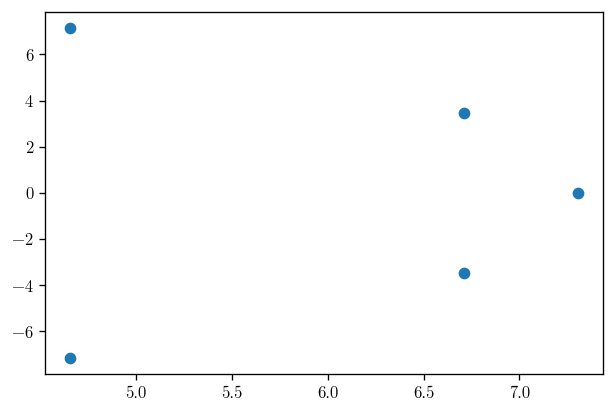

In [1166]:
# Make sure the roots are not near the domain
plot_roots(q)

In [1019]:
# Rescale so q[-1] is 1
pr = [pi / q[-1] for pi in p]
qr = [qi / q[-1] for qi in q]

mpf('0.693147180559945309417232121458176568075500134360255254120680009493393621969694715605863326996418687542001481020570685733685520235758130557032670751635075961930727570828371435190307038623891673471123350115364497955239120475172681574932065155524734139525882950453007095326366642654104239157814952043740407')

In [1173]:
# Print closest representable numbers
def represent(x, base = 2**96):
    n = int(mp.nint(x * base))
    #if n < 0:
    #    n += 2**256
    # assert n >= 0 and n < 2**256
    return n

for pi in reversed(pr):
    print(f'{represent(pi)} // {float(pi)}')

print()
for qi in reversed(qr):
    print(f'{represent(qi)} // {float(qi)}')

477854134370404556630342282363 // 6.031367120048645
16718958074186125785429723300994 // 211.02291841207378
267406022731302253162841045679923 // 3375.138514453849
2405842938758026514885988413895746 // 30366.007015811778
12025579931005125156911976381633042 // 151784.15792288538
26449188498355588339771844097777124 // 333835.6924987834

79228162514264337593543950336 // 1.0
-2855989394907223263936484059900 // -36.04765406988995
50020603652535783019961831881945 // 631.3487788326532
-533845033583426703283633433725380 // -6738.071623045815
3604857256930695427073651918091429 // 45499.69534231811
-14423608567350463180887372962807573 // -182051.53457589805
26449188498355588339934803723976023 // 333835.6924987834


In [933]:
for i in reversed(range(6)):
    e = -2**i
    print(f'{e}, {represent(e)}, {represent(mp.exp(mp.mpf(e)))}')

-32, -2535301200456458802993406410752, 1003358566231181
-16, -1267650600228229401496703205376, 8915955111228592727647
-8, -633825300114114700748351602688, 26578087600922394298733672
-4, -316912650057057350374175801344, 1451114414429211511965335629
-2, -158456325028528675187087900672, 10722365814184344471345157570
-1, -79228162514264337593543950336, 29146412150787779157341161347


In [1174]:
def eval_poly(c, x):
    r = c[-1]
    for c in reversed(c[:-1]):
        # print(represent(r))
        r = r * x + c
    return r

In [1175]:
def range_reduce(x):
    k = mp.nint(x / mp.log(2))
    k = mp.floor(x / mp.log(2) + 0.5)
    r = x - k * mp.log(2)
    assert r >= start and r <= stop
    return r, k

In [1176]:
x = linspace(-42, 135, 10000)
#x = linspace(-5, 5, 10000)
r = [range_reduce(x)[0] for x in x]
k = [range_reduce(x)[1] for x in x]

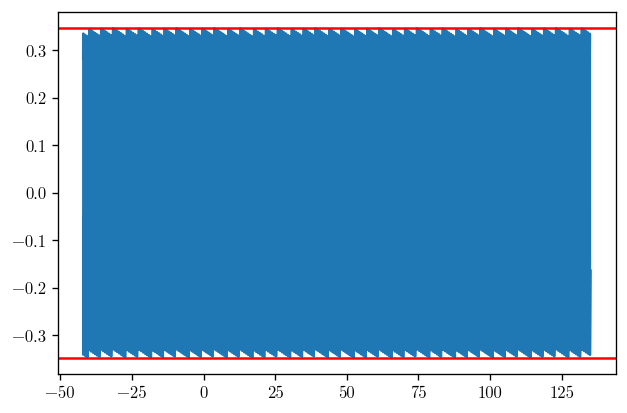

In [1177]:
plt.plot(x, r)
plt.axhline(start, color='red')
plt.axhline(stop, color='red')

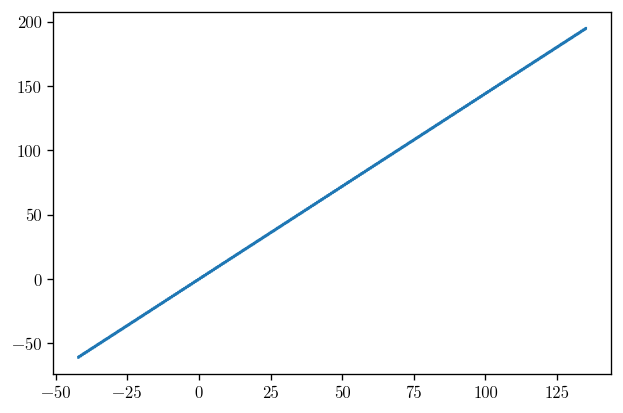

In [1178]:
plt.plot(x, k)

In [1180]:
mp.exp(start), mp.exp(stop)

(mpf('0.7071067811865475244008443621048490392845'),
 mpf('1.414213562373095048801688724209698078569'))

In [1181]:
96 + 196

292

In [1187]:
mp.log(1.5 * 3814697265625 * 2**96) / mp.log(2)

mpf('138.37966820869367844311948867475683967475')

In [1188]:
256 - 139

117

In [1197]:
mp.floor(mp.log((mp.mpf(2**255) - 1) / 1e18) * 1e18)

mpf('135305999368893231589.0')

In [1198]:
mp.exp(mp.mpf(135305999368893231589) / 1e18) * 1e18 / 2**255

mpf('0.99999999999999999992965521248353087781244')

In [1199]:
57896044618658097649809650851135836446708721278684416180224000000000000000000 / 1e18

5.78960446186581e+58

In [1201]:
mp.exp(mp.mpf(135305999368893231588) / 1e18) - 57896044618658097649809650851135836446708721278684416180224000000000000000000 / 1e18

mpf('-4.2039921047687509331676632734967562690888e+42')

In [1202]:
117 + 78

195

In [1203]:
5**18 / 2**78

1.2621774483536189e-11

In [1204]:
1104 - 721

383

In [1205]:
1604 - 1104

500

In [1206]:
135305999368893231589 / 1e18

135.30599936889323

In [1207]:
1557 - 1101

456

In [1208]:
2013 - 1557

456

In [1209]:
477854134370404556630342282363 / 2**96

6.031367120048645